# Comparing different models for Brazilian Inflation Index Prediction

Objective: get an inflation prediction that a company can use to:


*Better manage its cash flow and optimally adjust its prices and cost structure.


### Requirements

In [ ]:
%%capture
!pip install pmdarima
!pip install sktime
!pip install statsmodels
!pip install LightGBM

In [ ]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.style.use('bmh')

In [ ]:
# ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sktime.forecasting.arima import AutoARIMA

In [ ]:
# ML
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
# Support
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### Data Extraction


In [ ]:
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
ipca = pd.read_json(url)
ipca.head()

,data,valor
0,01/01/1980,6.62
1,01/02/1980,4.62
2,01/03/1980,6.04
3,01/04/1980,5.29
4,01/05/1980,5.70


### Data after Plano Real (1994 and beyond)

In [ ]:
ipca = ipca[250:502].reset_index()
ts_ipca = pd.DataFrame(ipca['valor'])
ts_ipca.head()

,valor
0,0.32
1,0.59
2,0.57
3,0.46
4,0.38


In [ ]:
print('p-valor:',adfuller(ts_ipca)[1])

p-valor: 0.01984317642650956


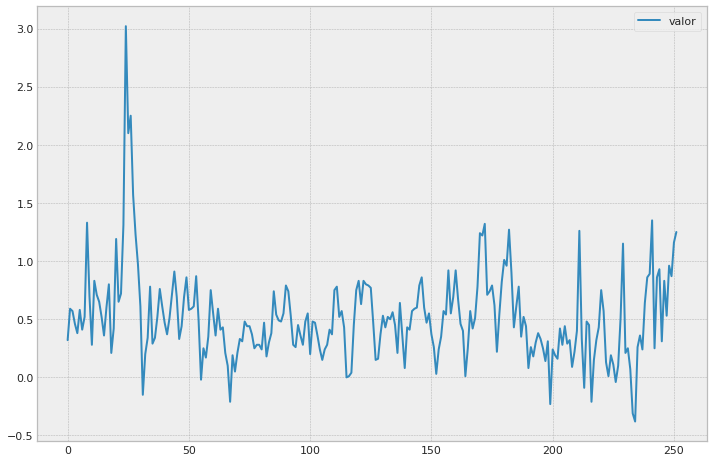

In [ ]:
ts_ipca.plot(figsize=(12,8))

### Train test split (90/10)

In [ ]:
train = ts_ipca[:int(-len(ts_ipca)*0.1)]
test = ts_ipca[int(-len(ts_ipca)*0.1):]

## Econometric Model

### SARIMA

In [ ]:
arima_model = pm.auto_arima(train,max_p = 10,max_q=10,m=12)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  227
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.629
Date:                              Tue, 23 Nov 2021   AIC                             67.258
Time:                                      21:53:58   BIC                             84.383
Sample:                                           0   HQIC                            74.168
                                              - 227                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0104      0.017      0.616      0.538      -0.023       0.044
ar.L1          0.6707      0.049     13.683      0.000       0.575       0.767
ar.S.L12       0.9365      0.103      9.110      0.000       0.735       1.138
ma.S.L12      -0.8747      0.146     -5.992      0.000      -1.161      -0.589
sigma2         0.0747      0.004     19.617      0.000       0.067       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1425.48
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.82
Prob(H) (two-sided):                  0.04   Kurtosis:                        14.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecasting

In [ ]:
frcst = arima_model.predict(25)
frcst = pd.Series(frcst, index = test.index)
frcst = frcst.rename("ARIMA")

MAE:  0.4018033040786437
MAPE:  0.9366154609533894
RMSE:  0.47234447951474884
NRMSE:  0.8345


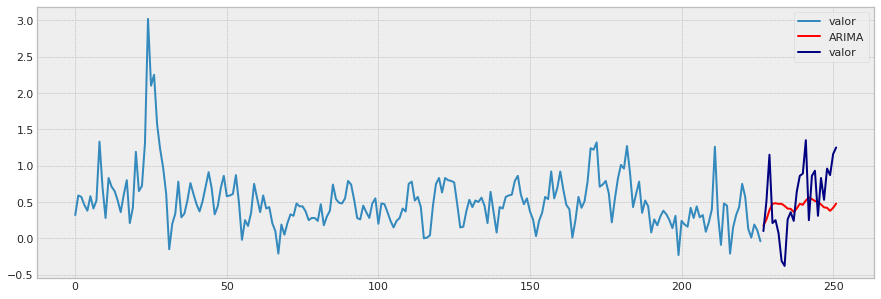

In [ ]:
mae = mean_absolute_error(test, frcst)
mape = mean_absolute_percentage_error(test, frcst)
rmse = mean_squared_error(test, frcst, squared=False)
mean = float(test.mean())
nrmse = round(rmse/mean, 4)

print('MAE: ', mae)
print('MAPE: ', mape)
print('RMSE: ', rmse)
print('NRMSE: ', nrmse)

fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(data=train)
frcst.plot(ax=ax, color='red',legend = True)
test.plot(ax=ax, color = 'navy',legend=True)

## Machine Learning Models

### Plot and Grid Search

In [ ]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    fig, ax = plt.subplots(figsize=(15,5))
    #plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(ax=ax, label="train", color="b")
    series_test.plot(ax=ax, label="test", color="navy")
    forecast.index = series_test.index
    forecast.plot(ax=ax, label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

In [ ]:
# Processo de seleção de hiperparâmetros do modelo por meio de validação cruzada. Reduz erro a cada iteração da CV.
# param_grid: diferentes tamanhos da janela de previsão.

def grid_serch_forecaster(df_train, df_test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(df_train) * 0.9))
    gscv = ForecastingGridSearchCV(
        forecaster, cv=cv, param_grid=param_grid
    )
    gscv.fit(df_train)
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh = np.arange(len(df_test)) + 1
    y_pred = gscv.predict(fh=fh)

    mae = mean_absolute_error(df_test, y_pred)
    mape = mean_absolute_percentage_error(df_test, y_pred)
    rmse = mean_squared_error(df_test, y_pred, squared=False)
    mean = float(df_test.mean())
    nrmse = round(rmse/mean, 4)

    print('MAE: ', mae)
    print('MAPE: ', mape)
    print('RMSE: ', rmse)
    print('NRMSE: ', nrmse)
    
    return plot_forecast(df_train, df_test, y_pred)

### Support Vector Machine

In [ ]:
def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster
    regressor = SVR()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )
    return forecaster

best params: {'forecast__window_length': 1}
MAE:  0.404037450616989
MAPE:  0.9676390399794235
RMSE:  0.4666464480159935
NRMSE:  0.8245


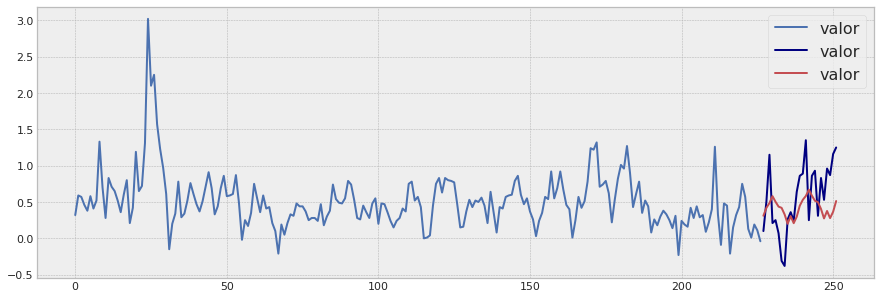

In [ ]:
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [1, 6, 12, 24]}

lgb_mae, lgb_mape = grid_serch_forecaster(
    train, test, forecaster, param_grid
)


### Decision Tree

In [ ]:
def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster
    regressor = DecisionTreeRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )
    return forecaster

best params: {'forecast__window_length': 6}
MAE:  0.44742407407407403
MAPE:  1.1267573100664625
RMSE:  0.5044032084279088
NRMSE:  0.8912


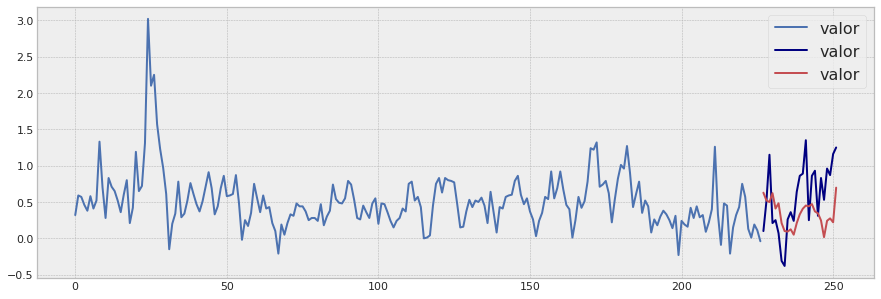

In [ ]:
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [1, 6, 12, 24]}

lgb_mae, lgb_mape = grid_serch_forecaster(
    train, test, forecaster, param_grid
)

### Random Forest (Bagging)

In [ ]:
# Extraídos subconjuntos do treino. Em cada um deles é treinada uma árvore em paralelo. Resultado é a média das árvores.

def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster
    regressor = RandomForestRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )
    return forecaster

best params: {'forecast__window_length': 1}
MAE:  0.4087100392156862
MAPE:  1.2247950676498263
RMSE:  0.48150161083546333
NRMSE:  0.8507


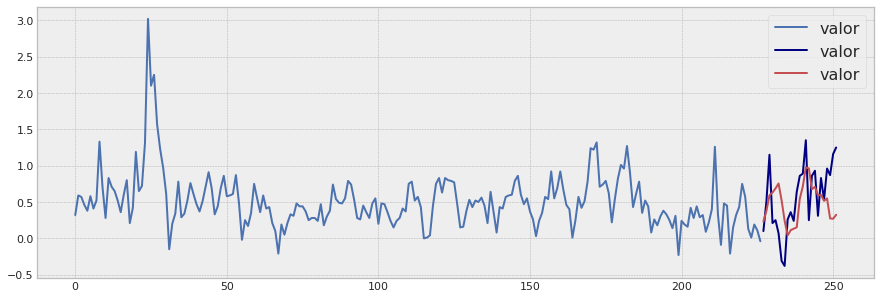

In [ ]:
forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [1, 6, 12, 24]}

lgb_mae, lgb_mape = grid_serch_forecaster(
    train, test, forecaster, param_grid
)

### LightGBM (Boosting)

In [ ]:
# Extraídos subconjuntos do treino. Em cada um deles é treinada uma árvore em sequência, de modo que o gradiente parte da árvore anterior. 
# Resultado é atingido em um valor específico do custo ou após um certo número de árvores treinadas.

def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster
    regressor = lgb.LGBMRegressor()
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
            #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )
    return forecaster

best params: {'forecast__window_length': 24}
MAE:  0.4408868265752032
MAPE:  1.0138007139003375
RMSE:  0.4983717412064579
NRMSE:  0.8805


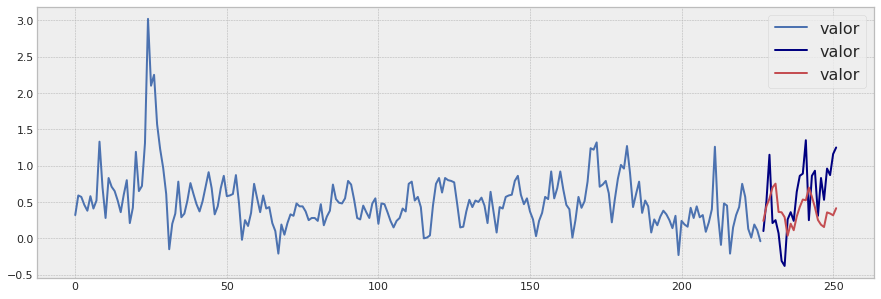

In [ ]:
import warnings
warnings.filterwarnings('ignore')

forecaster = create_forecaster_w_desesonalizer()
param_grid = {"forecast__window_length": [1, 6, 12, 24]}

lgb_mae, lgb_mape = grid_serch_forecaster(
    train, test, forecaster, param_grid
)

## Conclusion: SVM (best) > SARIMA > Random Forest > Decision Tree > LightGBM (worst)
## Focus on the problem, not only on the model itself!